In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import numpy as np

from keras import optimizers
from keras import models
from keras.layers.core import Activation, Reshape, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils.np_utils import to_categorical

import  sklearn
from sklearn import datasets, linear_model
from sklearn.preprocessing import MinMaxScaler


IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

Using TensorFlow backend.


# Getting Started

The dataset we will work on is made of figures much like the ones below. Our goal is multiple:
- Classify the images with a Multi-Layer perceptron and a Convolutional Neural Network
- Regress its vertices with a Multi-Layer perceptron and a Convolutional Neural Network
- Remove noise with a denoising autoencoder

Text(0.5,1,'Noisy Triangle')

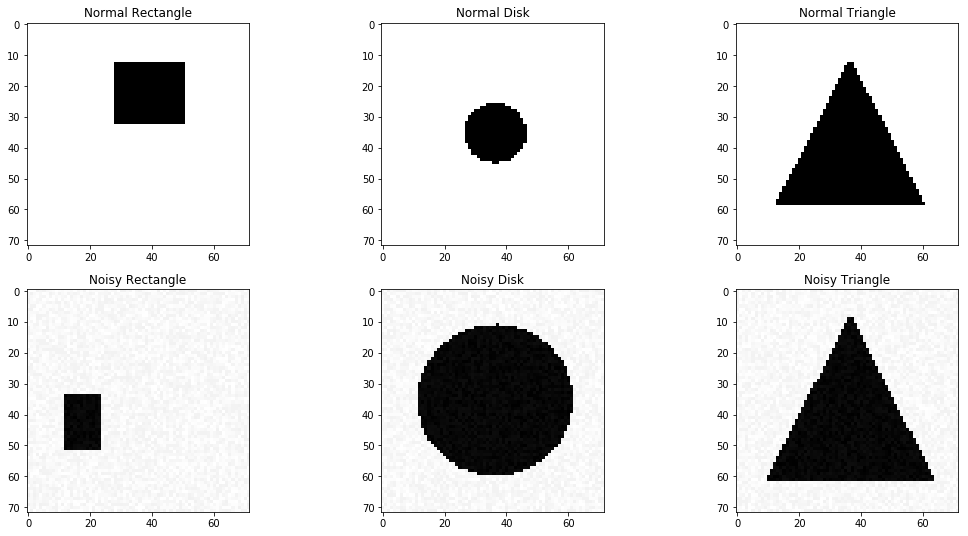

In [2]:
# Figures
plt.figure(figsize = (18, 9))

# Rectangle
plt.subplot(2, 3, 1)
im = generate_a_rectangle(0, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title('Normal Rectangle')
# Disk
plt.subplot(2, 3, 2)
im = generate_a_disk(0)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title('Normal Disk')
# Triangle
plt.subplot(2, 3, 3)
[im, v] = generate_a_triangle(0, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title('Normal Triangle')

# Rectangle
plt.subplot(2, 3, 4)
im = generate_a_rectangle(15, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title('Noisy Rectangle')
# Disk
plt.subplot(2, 3, 5)
im = generate_a_disk(15)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title('Noisy Disk')
# Triangle
plt.subplot(2, 3, 6)
[im, v] = generate_a_triangle(15, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title('Noisy Triangle')

In [3]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    for i in range(nb_samples):
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

# Simple Classification

## Generate datasets
We create a training set with 300 geometric figures and a testing set with 40 figures, both with 20% noise.

In [4]:
[X_train, Y_train] = generate_dataset_classification(300, 20)
y_binary_train = to_categorical(Y_train)
[X_test, Y_test] = generate_dataset_classification(40, 20)
y_binary_test = to_categorical(Y_test)

## Setup
- Our model will be a linear classifier (1-layer perceptron). 
- The problem is a <b>multi-class classification</b> and therefore we choose the <b>categorical_cross_entropy loss</b> in conjuntion with the <b>softmax activation</b>.
- The <b>remaining setup</b> is done in accordance with the <b>project description</b>.

In [5]:
# Build model with SGD
model_sgd = Sequential()
model_sgd.add(Dense(3, input_dim=5184, activation="softmax"))
model_sgd.compile(loss='categorical_crossentropy', optimizer='sgd', metrics = ['accuracy'])
history_sgd = model_sgd.fit(X_train, y_binary_train, epochs=15, batch_size = 32, validation_data = (X_test, y_binary_test))

# Build model with Adam
model_adam = Sequential()
model_adam.add(Dense(3, input_dim=5184, activation="softmax"))
model_adam.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
history_adam = model_adam.fit(X_train, y_binary_train, epochs=20, batch_size = 32, validation_data = (X_test, y_binary_test))

Train on 300 samples, validate on 40 samples
Epoch 1/15
300/300 [==============================] - 0s 583us/step - loss: 7.0340 - acc: 0.3433 - val_loss: 5.1128 - val_acc: 0.5000
Epoch 2/15
300/300 [==============================] - 0s 92us/step - loss: 6.9774 - acc: 0.4500 - val_loss: 7.1738 - val_acc: 0.3500
Epoch 3/15
300/300 [==============================] - 0s 131us/step - loss: 7.8423 - acc: 0.3200 - val_loss: 4.2427 - val_acc: 0.7000
Epoch 4/15
300/300 [==============================] - 0s 133us/step - loss: 6.5200 - acc: 0.4833 - val_loss: 4.1513 - val_acc: 0.7500
Epoch 5/15
300/300 [==============================] - 0s 144us/step - loss: 6.1348 - acc: 0.5267 - val_loss: 4.0399 - val_acc: 0.7500
Epoch 6/15
300/300 [==============================] - 0s 159us/step - loss: 5.7234 - acc: 0.6433 - val_loss: 4.0488 - val_acc: 0.7500
Epoch 7/15
300/300 [==============================] - 0s 108us/step - loss: 5.9520 - acc: 0.5633 - val_loss: 4.1927 - val_acc: 0.7000
Epoch 8/15
300/300

## Validations of the models

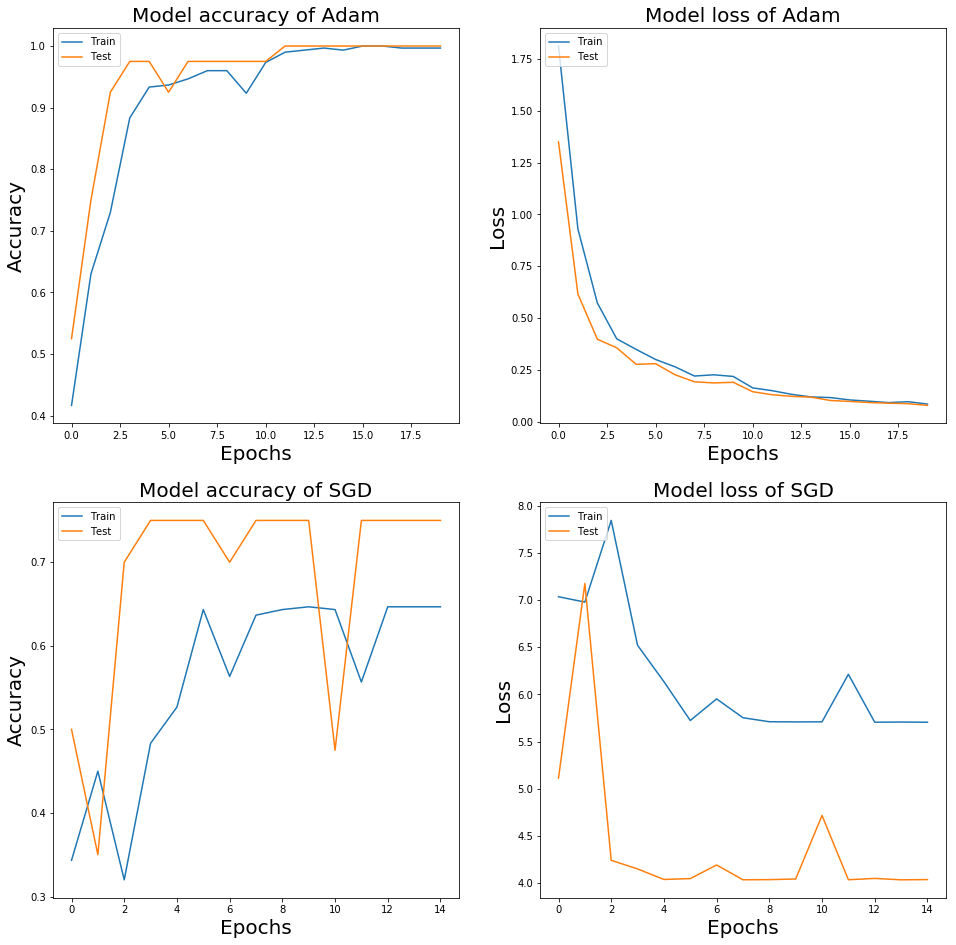

In [6]:
# summarize history for accuracy
plt.figure(figsize = (16, 16))

plt.subplot(2, 2, 1)
plt.plot(history_adam.history['acc'])
plt.plot(history_adam.history['val_acc'])
plt.title('Model accuracy of Adam', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Epochs', fontsize = 20)
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(2, 2, 2)
plt.plot(history_adam.history['loss'])
plt.plot(history_adam.history['val_loss'])
plt.title('Model loss of Adam', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epochs', fontsize = 20)
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(2, 2, 3)
plt.plot(history_sgd.history['acc'])
plt.plot(history_sgd.history['val_acc'])
plt.title('Model accuracy of SGD', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Epochs', fontsize = 20)
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(2, 2, 4)
plt.plot(history_sgd.history['loss'])
plt.plot(history_sgd.history['val_loss'])
plt.title('Model loss of SGD', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epochs', fontsize = 20)
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

As we see, not only Adam performs better than SGD, but it overfits less as well.

In [7]:
# Results for a generated disk
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
print('The result of the model with SGD: ' + str(max(model_sgd.predict(X_test), key = len)))
print('The result of the model with Adam: ' + str(max(model_adam.predict(X_test), key = len)))

The result of the model with SGD: [1. 0. 0.]
The result of the model with Adam: [0. 1. 0.]


For the generated disk, only Adam detects it (higher probability are casted to the class).

# Visualisation of the solution

In [8]:
weights = model_adam.get_weights()

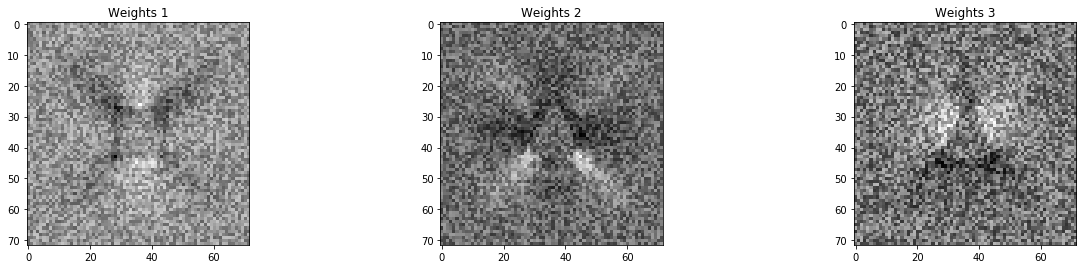

In [9]:
# Plot
plt.figure(figsize = (21, 9))
for i in range(1, 4):
    plt.subplot(2, 3, i)
    plt.imshow(weights[0][:,i-1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    plt.title('Weights ' + str(i))

As we can see, each of the Weights correspond to a geometric form, in the following order: rectangle, disk, triangle. This is expected as each of those weights were trained to detect the corresponding figure.

# A more difficult classification problem

### Dataset construction

In [10]:
# Prepare dataset
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
y_binary_train = to_categorical(Y_train)
[X_test, y_binary_test] = generate_test_set_classification()

### Linear Models

In [11]:
# Build model with SGD
model_sgd = Sequential()
model_sgd.add(Dense(3, input_dim=5184, activation="softmax"))
model_sgd.compile(loss='categorical_crossentropy', optimizer='sgd', metrics = ['accuracy'])
history_sgd = model_sgd.fit(X_train, y_binary_train, epochs=15, batch_size = 32, validation_data = (X_test, y_binary_test))

# Build model with Adam
model_adam = Sequential()
model_adam.add(Dense(3, input_dim=5184, activation="softmax"))
model_adam.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
history_adam = model_adam.fit(X_train, y_binary_train, epochs=20, batch_size = 32, validation_data = (X_test, y_binary_test))

Train on 300 samples, validate on 300 samples
Epoch 1/15
300/300 [==============================] - 0s 732us/step - loss: 9.7868 - acc: 0.2933 - val_loss: 10.7991 - val_acc: 0.3300
Epoch 2/15
300/300 [==============================] - 0s 187us/step - loss: 11.2289 - acc: 0.3033 - val_loss: 10.7991 - val_acc: 0.3300
Epoch 3/15
300/300 [==============================] - 0s 150us/step - loss: 11.2289 - acc: 0.3033 - val_loss: 10.7991 - val_acc: 0.3300
Epoch 4/15
300/300 [==============================] - 0s 115us/step - loss: 11.2289 - acc: 0.3033 - val_loss: 10.7991 - val_acc: 0.3300
Epoch 5/15
300/300 [==============================] - 0s 147us/step - loss: 11.2289 - acc: 0.3033 - val_loss: 10.7991 - val_acc: 0.3300
Epoch 6/15
300/300 [==============================] - 0s 114us/step - loss: 11.2289 - acc: 0.3033 - val_loss: 10.7991 - val_acc: 0.3300
Epoch 7/15
300/300 [==============================] - 0s 227us/step - loss: 11.2289 - acc: 0.3033 - val_loss: 10.7991 - val_acc: 0.3300
Epo

## Validation of the linear models

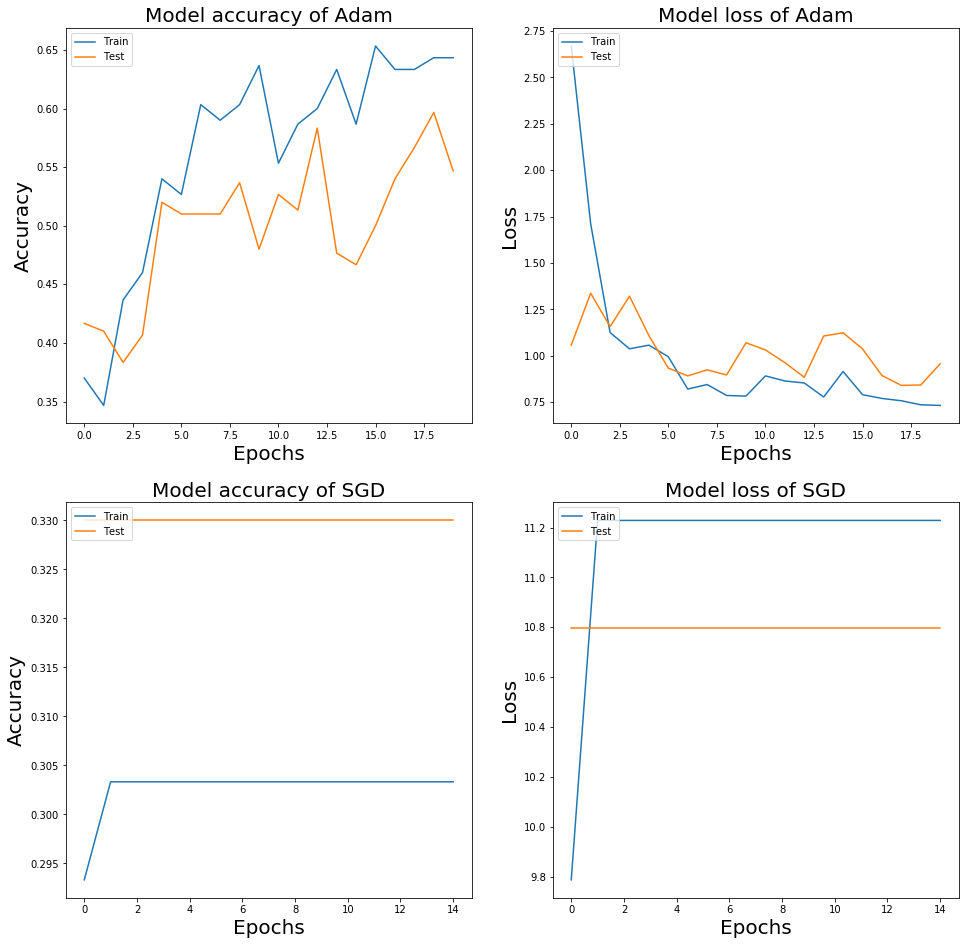

In [12]:
# summarize history for accuracy
plt.figure(figsize = (16, 16))

plt.subplot(2, 2, 1)
plt.plot(history_adam.history['acc'])
plt.plot(history_adam.history['val_acc'])
plt.title('Model accuracy of Adam', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Epochs', fontsize = 20)
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(2, 2, 2)
plt.plot(history_adam.history['loss'])
plt.plot(history_adam.history['val_loss'])
plt.title('Model loss of Adam', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epochs', fontsize = 20)
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(2, 2, 3)
plt.plot(history_sgd.history['acc'])
plt.plot(history_sgd.history['val_acc'])
plt.title('Model accuracy of SGD', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Epochs', fontsize = 20)
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(2, 2, 4)
plt.plot(history_sgd.history['loss'])
plt.plot(history_sgd.history['val_loss'])
plt.title('Model loss of SGD', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epochs', fontsize = 20)
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

As we can see, the SGD fails miserably to detect forms when the free_location is enabled. The Adam optimizer performs better and is prone to overfit quickly. And in terms of accuracy, we are much lower than in the simpler problem.

In [13]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
print('The result of the model with SGD: ' + str(max(model_sgd.predict(X_test), key = len)))
print('The result of the model with Adam: ' + str(max(model_adam.predict(X_test), key = len)))

The result of the model with SGD: [0. 1. 0.]
The result of the model with Adam: [1. 0. 0.]


For the generated disk, only Adam detects it (higher probability are casted to the class).

## CNN

### Dataset construction

The only change is the reshape to obtain images instead of vectors.

In [14]:
# Prepare dataset
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
X_train_classification = X_train.reshape(X_train.shape[0], 72, 72, 1) 
y_binary_train = to_categorical(Y_train)
[X_test, y_binary_test] = generate_test_set_classification()
X_test_classification = X_test.reshape(X_test.shape[0], 72, 72, 1)

### CNN setup

Our architecture is the following:
- 16 5×5 filters with a Max Pooling layer as our first layers (suggested in the description)
- 32 2x2 filters with a Max Pooling layer
- Flatten layer
- Fully connected layer with 16 neurons
- Output layer
- Categorical cross entropy and softmax as the last activation are chosen for the same reasons than in the previous problem.
- Dropout to correct regularize the network, therefore reducing overfitting. We add one Dropout layer before the fully connected layer
    * Without dropout: 0.66
    * With dropout before fully connected layer: 0.73

In [15]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

model_cnn = Sequential()
model_cnn.add(Conv2D(filters = 16, kernel_size = 5, activation='relu', padding = 'same', input_shape=(72, 72, 1), data_format='channels_last'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_last')) 
model_cnn.add(Conv2D(filters = 32, kernel_size = 2, activation='relu', padding = 'same', data_format='channels_last'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_last')) 
model_cnn.add(Flatten()) 
#model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(100, activation='relu')) 
model_cnn.add(Dense(50, activation='relu')) 
model_cnn.add(Dense(3, activation='softmax')) 
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_cnn = model_cnn.fit(X_train_classification, y_binary_train, batch_size=32, epochs=20, verbose=1, validation_data = (X_test_classification, y_binary_test))

Train on 300 samples, validate on 300 samples
Epoch 1/20
300/300 [==============================] - 4s 12ms/step - loss: 1.1094 - acc: 0.3000 - val_loss: 1.0570 - val_acc: 0.3600
Epoch 2/20
300/300 [==============================] - 2s 7ms/step - loss: 0.9937 - acc: 0.5833 - val_loss: 0.9096 - val_acc: 0.5967
Epoch 3/20
300/300 [==============================] - 2s 7ms/step - loss: 0.8355 - acc: 0.6100 - val_loss: 0.8785 - val_acc: 0.5200
Epoch 4/20
300/300 [==============================] - 2s 7ms/step - loss: 0.7542 - acc: 0.6300 - val_loss: 0.7304 - val_acc: 0.6800
Epoch 5/20
300/300 [==============================] - 2s 7ms/step - loss: 0.6508 - acc: 0.7233 - val_loss: 0.7456 - val_acc: 0.6167
Epoch 6/20
300/300 [==============================] - 2s 7ms/step - loss: 0.5794 - acc: 0.7867 - val_loss: 0.6543 - val_acc: 0.7100
Epoch 7/20
300/300 [==============================] - 2s 7ms/step - loss: 0.4812 - acc: 0.8333 - val_loss: 0.6714 - val_acc: 0.7033
Epoch 8/20
300/300 [=========

In [16]:
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 72, 72, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10368)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1036900   
_________________________________________________________________
dense_6 (Dense)              (None, 50)                5050      
__________

### CNN evaluation

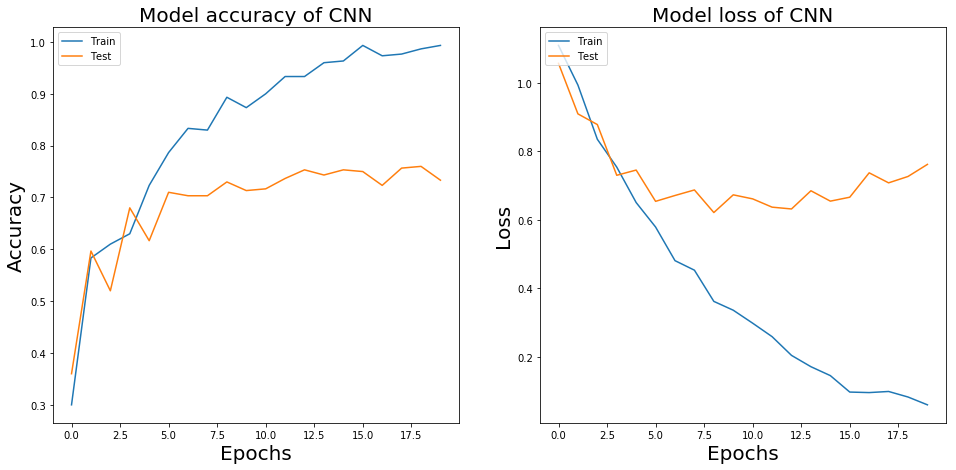

In [17]:
# summarize history for accuracy
plt.figure(figsize = (16, 16))

plt.subplot(2, 2, 1)
plt.plot(history_cnn.history['acc'])
plt.plot(history_cnn.history['val_acc'])
plt.title('Model accuracy of CNN', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Epochs', fontsize = 20)
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(2, 2, 2)
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model loss of CNN', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epochs', fontsize = 20)
plt.legend(['Train', 'Test'], loc='upper left')

The values of the loss are plotted below and indicates that the algorithm converges well. We have better results than with a Linear Model.

# A Regression Problem

In [18]:
def normalizer(array):
    nb_samples = array.shape[0]
    normalized_array = np.copy(array)
    
    for k in range(nb_samples):
        x1, y1, x2, y2, x3, y3 = array[k, 0], array[k, 1], array[k, 2], array[k, 3], array[k, 4], array[k, 5]
        couple = {y1:x1, y2:x2, y3:x3}
        couple_list = list(couple)
        couple_list.sort()
        normalized = []
        
        for key in couple_list:
            normalized.append(couple[key])
            normalized.append(key)
        
        normalized_array[k] = normalized
    
    return(normalized_array)

### Dataset construction

In [19]:
# Generate training and testing sets
[X_train, Y_train] = generate_dataset_regression(300, 20)
X_train = X_train.reshape(X_train.shape[0], 72, 72, 1) 
[X_test, Y_test] = generate_test_set_regression()
X_test = X_test.reshape(X_test.shape[0], 72, 72, 1) 

# Normalize response
minmax = MinMaxScaler()
Y_train_norm = minmax.fit_transform(Y_train)
Y_test_norm = minmax.transform(Y_test)

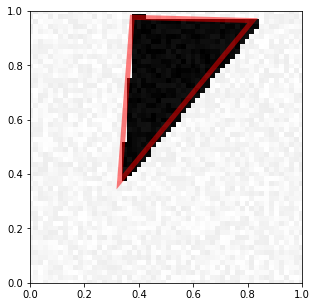

In [20]:
visualize_prediction(X_train[0], Y_train_norm[0])

### Model setup

We use a similar setup than the classification settting. However, we choose:
- The Mean Squared Error as our loss (no longer a classification problem)
- Use relu as the last activation

In [21]:
# Regression model
model_regression = Sequential()
model_regression.add(Conv2D(filters = 16, kernel_size = 5, activation='relu', padding = 'same', input_shape=(72, 72, 1), data_format='channels_last'))
model_regression.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_last')) 
model_regression.add(Conv2D(filters = 32, kernel_size = 2, activation='relu', padding = 'same', data_format='channels_last'))
model_regression.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_last')) 
model_regression.add(Flatten()) 
model_regression.add(Dense(32, activation='relu')) 
model_regression.add(Dense(6)) 
model_regression.compile(loss='mean_squared_error', optimizer='adadelta')
history_cnn = model_regression.fit(X_train, Y_train_norm, batch_size=32, epochs=10, verbose=1, validation_data = (X_test, Y_test_norm))

Train on 300 samples, validate on 300 samples
Epoch 1/10
300/300 [==============================] - 2s 8ms/step - loss: 0.1468 - val_loss: 0.1063
Epoch 2/10
300/300 [==============================] - 2s 6ms/step - loss: 0.1032 - val_loss: 0.1027
Epoch 3/10
300/300 [==============================] - 2s 7ms/step - loss: 0.1007 - val_loss: 0.0749
Epoch 4/10
300/300 [==============================] - 2s 8ms/step - loss: 0.0766 - val_loss: 0.0788
Epoch 5/10
300/300 [==============================] - 2s 8ms/step - loss: 0.0716 - val_loss: 0.0681
Epoch 6/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0729 - val_loss: 0.0687
Epoch 7/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0646 - val_loss: 0.0744
Epoch 8/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0647 - val_loss: 0.0659
Epoch 9/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0647 - val_loss: 0.0670
Epoch 10/10
300/300 [==============================] -

## Evaluation

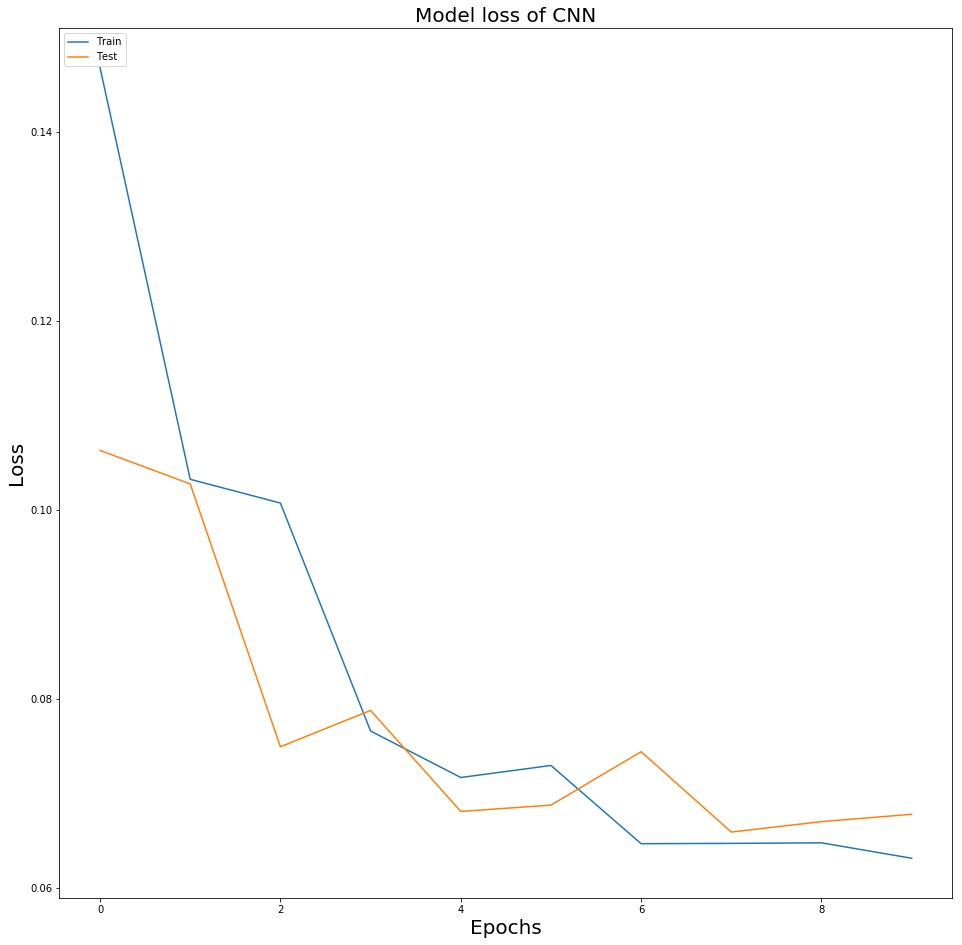

In [22]:
# Summarize history for accuracy
plt.figure(figsize = (16, 16))

plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model loss of CNN', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epochs', fontsize = 20)
plt.legend(['Train', 'Test'], loc='upper left')

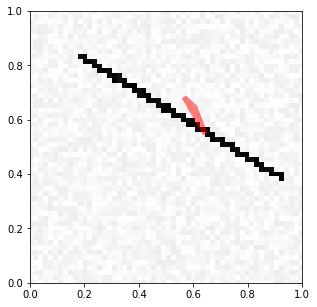

In [23]:
# Visualize predictions
predictions = model_regression.predict(X_test)
visualize_prediction(X_test[3], predictions[3])

The results are not those expected. I suspect that the normalization used is ill-suited or the network did not learn enough.

# Image Denoising

### Dataset construction

In [27]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata_noise = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata_noise, imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata_noise, imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata_noise, imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


In [28]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle()[0].shape[0]
    X = np.zeros([nb_samples, im_size])
    Y = np.zeros([nb_samples, im_size])
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            [X[i], Y[i]] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            [X[i], Y[i]] = generate_a_disk(noise, free_location)
        else:
            [X[i], Y[i], V] = generate_a_triangle(noise, free_location)
    X = X / float(255)
    Y = Y / float(255)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    return [X_test, Y_test]

In [30]:
# Generate training and testing sets
[X_train_seg, Y_train_seg] = generate_dataset_classification(300, 20)
X_train_seg = X_train_seg.reshape(X_train_seg.shape[0], 72, 72, 1) 
Y_train_seg = Y_train_seg.reshape(Y_train_seg.shape[0], 72, 72, 1) 
[X_test_seg, Y_test_seg] = generate_test_set_classification()
X_test_seg = X_test_seg.reshape(X_test_seg.shape[0], 72, 72, 1) 
Y_test_seg = Y_test_seg.reshape(Y_test_seg.shape[0], 72, 72, 1) 

### Model setup

The architecure is listed below. I did not use the BatchNormalization layer as I found it to degrade the loss evolution across epochs. I suspect BatchNomarlization works better with bigger data sets and deeper SegNets.

In [31]:
model = Sequential()

# Encoder
model.add(Convolution2D(filters = 32, kernel_size = (3, 3), padding = 'same', input_shape = (72, 72, 1), data_format = 'channels_last'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(filters = 32, kernel_size = (3, 3), padding = 'same', data_format = 'channels_last'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format = 'channels_last'))

model.add(Convolution2D(filters = 32, kernel_size = (3, 3), padding = 'same', data_format = 'channels_last'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(filters = 32, kernel_size = (3, 3), padding = 'same', data_format = 'channels_last'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format = 'channels_last'))

# Decoder
model.add(UpSampling2D(size = (2, 2), data_format = 'channels_last'))
model.add(Convolution2D(filters = 32, kernel_size = (3, 3), padding='same', data_format = 'channels_last'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(filters = 32, kernel_size = (3, 3), padding='same', data_format = 'channels_last'))
#model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(UpSampling2D(size = (2, 2), data_format = 'channels_last'))
model.add(Convolution2D(filters = 32, kernel_size = (3, 3), padding='same', data_format = 'channels_last'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(filters = 1, kernel_size = (3, 3), padding='same', data_format = 'channels_last'))
#model.add(BatchNormalization())
model.add(Activation('sigmoid'))

optimizer = optimizers.SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False)
model.compile(loss="binary_crossentropy", optimizer='adadelta', metrics=['accuracy'])

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 72, 72, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 36, 36, 32)        9248      
_________________________________________________________________
activation_3 (Activation)    (None, 36, 36, 32)        0         
__________

In [34]:
history_segnet = model.fit(X_train_seg, Y_train_seg, epochs = 5, validation_data = (X_test_seg, Y_test_seg))

Train on 300 samples, validate on 300 samples
Epoch 1/5
300/300 [==============================] - 18s 60ms/step - loss: 0.4702 - acc: 0.7746 - val_loss: 0.1827 - val_acc: 0.9065
Epoch 2/5
300/300 [==============================] - 17s 57ms/step - loss: 0.3303 - acc: 0.8833 - val_loss: 0.2350 - val_acc: 0.9414
Epoch 3/5
300/300 [==============================] - 17s 57ms/step - loss: 0.2265 - acc: 0.9406 - val_loss: 0.0613 - val_acc: 0.9797
Epoch 4/5
300/300 [==============================] - 17s 57ms/step - loss: 0.0859 - acc: 0.9688 - val_loss: 0.0718 - val_acc: 0.9776
Epoch 5/5
300/300 [==============================] - 17s 57ms/step - loss: 0.0625 - acc: 0.9746 - val_loss: 0.0470 - val_acc: 0.9843


### Evaluation

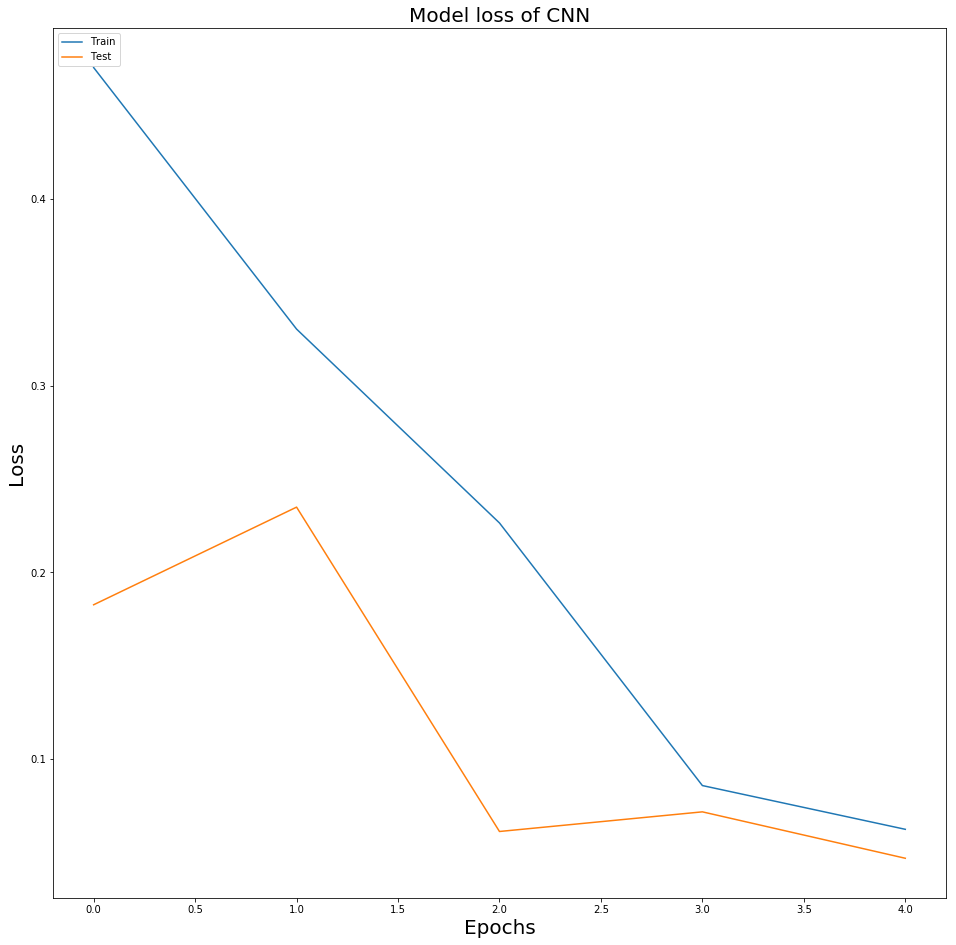

In [35]:
# Summarize history for accuracy
plt.figure(figsize = (16, 16))

plt.plot(history_segnet.history['loss'])
plt.plot(history_segnet.history['val_loss'])
plt.title('Model loss of CNN', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epochs', fontsize = 20)
plt.legend(['Train', 'Test'], loc='upper left')

In [37]:
# Predictions on test set
predictions = model.predict(X_test_seg)

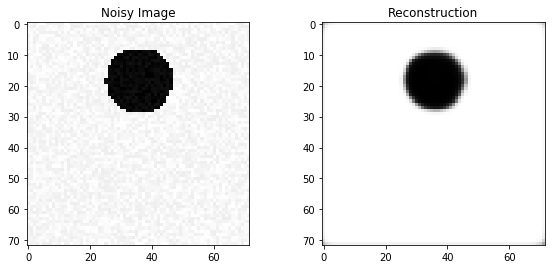

In [39]:
# Plots Before / After
plt.figure(figsize = (15, 9))
plt.subplot(2, 3, 1)
plt.imshow(X_test_seg[0].reshape(72, 72), cmap = 'gray')
plt.title('Noisy Image')
plt.subplot(2, 3, 2)
plt.imshow(predictions[0].reshape(72, 72), cmap = 'gray')
plt.title('Reconstruction')
plt.show()